In [2]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 26.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [161]:
import pandas as pd
import os
from pathlib import Path
import re
import sqlite3
import requests
from functools import reduce
import matplotlib.pyplot as plt
import geopandas as gpd

pd.set_option('display.max_columns', None)

In [4]:
stasiun_mapping = {
    'DKI1': 'Jakarta Pusat',
    'DKI2': 'Jakarta Utara',
    'DKI3': 'Jakarta Selatan',
    'DKI4': 'Jakarta Timur',
    'DKI5': 'Jakarta Barat'
}

In [5]:
# Define column mapping to match data.md convention
column_mapping = {
    'pm10': 'pm_sepuluh',
    'so2': 'sulfur_dioksida',
    'co': 'karbon_monoksida',
    'o3': 'ozon',
    'no2': 'nitrogen_dioksida',
    'critical': 'parameter_pencemar_kritis',
    'categori': 'kategori',
    'lokasi_spku': 'stasiun'
}

# Define column order to match data.md
column_order = [
    'periode_data', 'tanggal', 'stasiun', 'pm_sepuluh',
    'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida',
    'max', 'parameter_pencemar_kritis', 'kategori'
]


final_year = 2019

# Define the folder path and years to combine
ispu_folder = Path("data/ISPU")
years_to_combine = [i for i in range(2015, final_year + 1, 1)]

# List to store dataframes
dfs = []

# Load and standardize files that contain the desired years
for file_path in ispu_folder.glob("*.csv"):
    # Check if any of the desired years is in the filename
    for year in years_to_combine:
        if str(year) in file_path.name:
            df_temp = pd.read_csv(file_path)
            
            print(f"Loaded: {file_path.name}")
            print(f"  Original columns: {list(df_temp.columns)}")
            
            # Rename columns to match convention
            df_temp = df_temp.rename(columns=column_mapping)
            
            # Add missing columns with None
            for col in column_order:
                if col not in df_temp.columns:
                    df_temp[col] = None
            
            # Reorder columns to match data.md
            df_temp = df_temp[column_order]
            
            print(f"  Standardized to: {list(df_temp.columns)}")
            print(f"  Rows: {len(df_temp)}\n")
            
            dfs.append(df_temp)
            break

print(f"Total files loaded: {len(dfs)}")

# Combine all dataframes
df_combined = pd.concat(dfs, ignore_index=True)

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2015-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori', 'lokasi_spku']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 365

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2016-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori']
  Standardized to: ['periode_data', 'tanggal', 'stasiun', 'pm_sepuluh', 'sulfur_dioksida', 'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max', 'parameter_pencemar_kritis', 'kategori']
  Rows: 1830

Loaded: indeks-standar-pencemaran-udara-(ispu)-tahun-2017-komponen-data.csv
  Original columns: ['periode_data', 'tanggal', 'stasiun', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'cate

In [6]:
# Replace empty strings and "---" with NULL (NaN)
df_combined = df_combined.replace(['', '---', ' ', '  '], pd.NA)
df_combined = df_combined[df_combined['kategori'] != 'TIDAK ADA DATA']

df_combined['tanggal'] = pd.to_datetime(
    df_combined['tanggal'], 
    format='mixed',  # Allows multiple formats
    dayfirst=False,  # Month comes first in ambiguous cases
    errors='raise'
)

# Convert pollutant columns to integers (pd.NA will remain as NaN for nullable Int64)
numeric_columns = ['pm_sepuluh', 'sulfur_dioksida', 
                   'karbon_monoksida', 'ozon', 'nitrogen_dioksida', 'max']

for col in numeric_columns:
    df_combined[col] = pd.to_numeric(df_combined[col], errors='coerce').astype('Int64')

In [7]:
# Function to extract station ID (DKIx format)
def extract_station_id(station_name):
    if pd.isna(station_name):
        return station_name
    # Extract DKI followed by a number
    match = re.search(r'DKI\d+', str(station_name), re.IGNORECASE)
    if match:
        return match.group(0).upper()
    return station_name

# Apply normalization to stasiun column
df_combined['stasiun'] = df_combined['stasiun'].apply(extract_station_id)

In [8]:
df_combined['ID'] = df_combined['tanggal'].astype(str) + '_' + df_combined['stasiun'].astype(str)
df_combined = df_combined[['ID'] + column_order]
df_combined = df_combined.sort_values(by=['tanggal']).reset_index(drop=True)
df_combined = df_combined.ffill()
# df_combined['kota'] = 

In [9]:
df_combined.info()

<class 'pandas.DataFrame'>
RangeIndex: 4663 entries, 0 to 4662
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   ID                         4663 non-null   str           
 1   periode_data               4663 non-null   int64         
 2   tanggal                    4663 non-null   datetime64[us]
 3   stasiun                    4663 non-null   str           
 4   pm_sepuluh                 4663 non-null   Int64         
 5   sulfur_dioksida            4663 non-null   Int64         
 6   karbon_monoksida           4663 non-null   Int64         
 7   ozon                       4663 non-null   Int64         
 8   nitrogen_dioksida          4663 non-null   Int64         
 9   max                        4663 non-null   Int64         
 10  parameter_pencemar_kritis  4663 non-null   str           
 11  kategori                   4663 non-null   str           
dtypes: Int64(6), date

In [10]:
df_combined.to_csv('data/ispu_2015-2019.csv', index=False)

In [11]:
df_combined

,ID,periode_data,tanggal,stasiun,pm_sepuluh,sulfur_dioksida,karbon_monoksida,ozon,nitrogen_dioksida,max,parameter_pencemar_kritis,kategori
0,2015-01-01_DKI1,201501,2015-01-01,DKI1,49,10,39,27,10,49,PM10,BAIK
1,2015-01-02_DKI2,201501,2015-01-02,DKI2,28,9,26,48,10,48,O3,BAIK
2,2015-01-03_DKI2,201501,2015-01-03,DKI2,27,10,28,44,10,44,O3,BAIK
3,2015-01-04_DKI2,201501,2015-01-04,DKI2,22,9,28,42,12,42,O3,BAIK
4,2015-01-05_DKI2,201501,2015-01-05,DKI2,25,9,25,32,7,32,O3,BAIK
...,...,...,...,...,...,...,...,...,...,...,...,...
4658,2019-12-27_DKI4,201912,2019-12-27,DKI4,55,38,26,84,11,84,O3,SEDANG
4659,2019-12-28_DKI2,201912,2019-12-28,DKI2,64,37,34,61,11,64,PM10,SEDANG
4660,2019-12-29_DKI5,201912,2019-12-29,DKI5,64,38,36,69,10,69,O3,SEDANG
4661,2019-12-30_DKI2,201912,2019-12-30,DKI2,77,37,55,89,9,89,O3,SEDANG


# QC

In [12]:
# Check for issues that might need cleanup
print("=== Data Quality Check ===\n")

# 1. Check for duplicate IDs
duplicates = df_combined[df_combined['ID'].duplicated(keep=False)]
print(f"Duplicate IDs: {len(duplicates)}")
if len(duplicates) > 0:
    print(duplicates[['ID', 'tanggal', 'stasiun', 'kategori']].head())

# 2. Check for missing values in key columns
print("\nMissing values in critical columns:")
print(df_combined[['ID', 'tanggal', 'stasiun', 'kategori']].isnull().sum())

# 3. Check for invalid station IDs
print("\nUnique station IDs:")
print(sorted(df_combined['stasiun'].unique()))

# 4. Check kategori values
print("\nKategori distribution:")
print(df_combined['kategori'].value_counts())

# 5. Check for invalid dates
print(f"\nInvalid dates (NaT): {df_combined['tanggal'].isna().sum()}")

# 6. Check for negative or unrealistic pollutant values
print("\nNegative pollutant values:")
for col in numeric_columns:
    neg_count = (df_combined[col] < 0).sum()
    if neg_count > 0:
        print(f"  {col}: {neg_count}")

=== Data Quality Check ===

Duplicate IDs: 345
                  ID    tanggal stasiun kategori
420  2016-01-12_DKI4 2016-01-12    DKI4   SEDANG
421  2016-01-12_DKI3 2016-01-12    DKI3     BAIK
423  2016-01-12_DKI3 2016-01-12    DKI3   SEDANG
424  2016-01-12_DKI2 2016-01-12    DKI2   SEDANG
425  2016-01-12_DKI5 2016-01-12    DKI5   SEDANG

Missing values in critical columns:
ID          0
tanggal     0
stasiun     0
kategori    0
dtype: int64

Unique station IDs:
['DKI1', 'DKI2', 'DKI3', 'DKI4', 'DKI5']

Kategori distribution:
kategori
SEDANG                2938
BAIK                   911
TIDAK SEHAT            778
SANGAT TIDAK SEHAT      36
Name: count, dtype: int64

Invalid dates (NaT): 0

Negative pollutant values:


# Data Wilayah Administrasi DKI Jakarta

In [13]:
# Load administrative region codes (optional reference)


url = "https://raw.githubusercontent.com/cahyadsn/wilayah/refs/heads/master/db/wilayah.sql"
response = requests.get(url)
response.raise_for_status()
sql_content = response.text

# Clean SQL
clean_sql = re.sub(r'^/\*.*?\*/\s*|--.*?$|ENGINE=\w+\s*|DEFAULT CHARSET=\w+\s*', '', 
                   sql_content, flags=re.DOTALL | re.MULTILINE)
clean_sql = clean_sql.replace('`', '').strip()

# Load to SQLite
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
cursor.execute("CREATE TABLE IF NOT EXISTS wilayah (kode TEXT PRIMARY KEY, nama TEXT)")

statements = [s.strip() for s in clean_sql.split(';') if s.strip() and 'INSERT INTO' in s.upper()]
for stmt in statements[:5000]:  # Limit for efficiency
    try:
        cursor.execute(stmt)
    except:
        pass

conn.commit()
df_wilayah = pd.read_sql_query("SELECT * FROM wilayah WHERE kode LIKE '31%'", conn)
print(f"Loaded {len(df_wilayah)} DKI Jakarta administrative codes")

Loaded 318 DKI Jakarta administrative codes


# Data Batas Wilayah Administrasi DKI Jakarta

In [19]:
# Helper Functions
import json
from shapely.geometry import Polygon, MultiPolygon

def parse_boundary_sql(sql_content):
    """Parse SQL file to extract boundary data."""
    lines = sql_content.split('\n')
    data = []
    
    for line in lines:
        line = line.strip()
        if line.startswith("('"):
            try:
                first_quote = line.find("'")
                second_quote = line.find("'", first_quote + 1)
                kode = line[first_quote+1:second_quote]
                
                third_quote = line.find("'", second_quote + 1)
                fourth_quote = line.find("'", third_quote + 1)
                nama = line[third_quote+1:fourth_quote]
                
                after_nama = line[fourth_quote+2:]
                parts = after_nama.split(',', 2)
                
                if len(parts) >= 3:
                    lat = parts[0].strip()
                    lng = parts[1].strip()
                    rest = parts[2]
                    path_start = rest.find("'")
                    path_end = rest.rfind("'")
                    if path_start != -1 and path_end != -1:
                        geom = rest[path_start+1:path_end]
                        data.append([kode, nama, lat, lng, geom])
            except:
                pass
    
    return pd.DataFrame(data, columns=['kode', 'nama', 'lat', 'lng', 'geom'])

def swap_coords(coord_list):
    """Recursively swap [lat,lng] to [lng,lat] for GeoJSON compatibility."""
    if isinstance(coord_list[0], (int, float)):
        return [coord_list[1], coord_list[0]]
    else:
        return [swap_coords(c) for c in coord_list]

def parse_geometry(geom_str):
    """Parse geometry string to Shapely Polygon/MultiPolygon."""
    try:
        coords = json.loads(geom_str)
        coords = swap_coords(coords)
        
        if isinstance(coords[0][0], (int, float)):
            return Polygon(coords)
        elif isinstance(coords[0][0][0], (int, float)):
            exterior = coords[0]
            holes = coords[1:] if len(coords) > 1 else []
            return Polygon(exterior, holes)
        else:
            polygons = []
            for poly_coords in coords:
                exterior = poly_coords[0]
                holes = poly_coords[1:] if len(poly_coords) > 1 else []
                polygons.append(Polygon(exterior, holes))
            return MultiPolygon(polygons)
    except Exception as e:
        print(f"Error parsing geometry: {e}")
        return None

def assign_to_nearest_region(gdf_points, gdf_boundaries, nama_col='kota_kabupaten'):
    """Assign unassigned points to nearest boundary with tie-breaking by current count."""
    unassigned_mask = gdf_points[nama_col].isna()
    unassigned_indices = gdf_points[unassigned_mask].index
    
    if len(unassigned_indices) == 0:
        return gdf_points
    
    print(f"Assigning {len(unassigned_indices)} samples to nearest boundaries...")
    current_counts = gdf_points[nama_col].value_counts().to_dict()
    
    for idx in unassigned_indices:
        point = gdf_points.loc[idx, 'geometry']
        distances = []
        
        for _, boundary_row in gdf_boundaries.iterrows():
            dist = point.distance(boundary_row['geometry'])
            nama = boundary_row['nama']
            count = current_counts.get(nama, 0)
            distances.append((dist, count, nama))
        
        distances.sort(key=lambda x: (x[0], x[1]))
        _, _, nearest_nama = distances[0]
        
        gdf_points.loc[idx, nama_col] = nearest_nama
        current_counts[nearest_nama] = current_counts.get(nearest_nama, 0) + 1
    
    return gdf_points

In [ ]:
# ────────────────────────────────────────────────
# Step 1: Download the SQL file content
# ────────────────────────────────────────────────
url = "https://raw.githubusercontent.com/cahyadsn/wilayah_boundaries/refs/heads/main/db/kab/wilayah_boundaries_kab_31.sql"
response = requests.get(url)
response.raise_for_status()          # fail early if download error
sql_content = response.text

# Clean the SQL content
clean_sql = re.sub(r'^/\*.*?\*/\s*', '', sql_content, flags=re.DOTALL | re.MULTILINE).strip()

# Additional cleaning
clean_sql = re.sub(r'--.*?$', '', clean_sql, flags=re.MULTILINE)  # Remove -- comments
clean_sql = re.sub(r'ENGINE=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove ENGINE
clean_sql = re.sub(r'DEFAULT CHARSET=\w+\s*', '', clean_sql, flags=re.IGNORECASE)  # Remove CHARSET
clean_sql = clean_sql.replace('`', '')  # Remove backticks

# ---

# Parse boundary data
df_batas_wilayah = parse_boundary_sql(clean_sql)

# Filter out Kepulauan Seribu (only keep mainland Jakarta)
df_batas_wilayah = df_batas_wilayah[df_batas_wilayah['kode'] != '31.01'].reset_index(drop=True)

print(f"Loaded {len(df_batas_wilayah)} mainland DKI Jakarta boundaries:")
print(df_batas_wilayah[['kode', 'nama']].to_string(index=False))

# ---

# Convert to GeoDataFrame
df_batas_wilayah['geometry'] = df_batas_wilayah['geom'].apply(parse_geometry)

gdf_boundaries = gpd.GeoDataFrame(
    df_batas_wilayah[df_batas_wilayah['geometry'].notna()], 
    geometry='geometry', 
    crs='EPSG:4326'
)

print(f"Created GeoDataFrame with {len(gdf_boundaries)} boundaries")
print(f"Bounds: {gdf_boundaries.total_bounds}")

# ---



# Data Kualitas Air Sungai

## csv

In [14]:
sungai = pd.read_csv('data/kualitas-air-sungai/data-kualitas-air-sungai-komponen-data.csv')

In [15]:
params_sungai = ['Kimia', 'Fisika', 'Biologi'] 

index_columns = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel',
       'nama_sungai', 'alamat', 'latitude', 'longitude']
parameter_columns = 'parameter'
value_columns = 'hasil_pengukuran'

In [16]:
sungai_dfs = []
for param in params_sungai:
    _sungai_df = sungai[sungai['jenis_parameter'] == param].sort_values(by=['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel'])
    _sungai_df = _sungai_df.pivot(index=index_columns, columns=parameter_columns, values=value_columns)
    # _sungai_df.columns = [f'{val}_{par}' for val, par in _sungai_df.columns]
    _sungai_df = _sungai_df.reset_index()
    print(len(_sungai_df))
    sungai_dfs.append(_sungai_df)

480
480
480


In [17]:
common_cols = ['periode_data', 'periode_pemantauan', 'bulan_sampling', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude']

sungai_df = reduce(lambda left, right: pd.merge(left, right, on=common_cols, how='inner'), sungai_dfs)
sungai_df.columns.name = None

In [ ]:
# Spatial join: Assign river samples to kota/kabupaten
gdf_sungai = gpd.GeoDataFrame(
    sungai_df,
    geometry=gpd.points_from_xy(sungai_df.longitude, sungai_df.latitude),
    crs='EPSG:4326'
)

gdf_sungai_with_region = gpd.sjoin(
    gdf_sungai, 
    gdf_boundaries[['nama', 'geometry']], 
    how='left', 
    predicate='within'
)

gdf_sungai_with_region = gdf_sungai_with_region.rename(columns={'nama': 'kota_kabupaten'})

# ---

if 'index_right' in gdf_sungai_with_region.columns:
    gdf_sungai_with_region = gdf_sungai_with_region.drop(columns=['index_right'])

# Assign unassigned samples to nearest boundary
gdf_sungai_with_region = assign_to_nearest_region(gdf_sungai_with_region, gdf_boundaries)

# Convert to regular DataFrame
sungai_df_with_region = pd.DataFrame(gdf_sungai_with_region.drop(columns=['geometry']))
sungai_df_with_region['kota_kabupaten'] = sungai_df_with_region['kota_kabupaten'].str.replace('Kota Administrasi ', '')

print(f"\n✓ All {len(sungai_df_with_region)} samples assigned to mainland DKI Jakarta regions")
print("\nDistribution:")
print(sungai_df_with_region['kota_kabupaten'].value_counts().to_string())

# ---

def add_stasiun_column(df, stasiun_mapping):
    """
    Add 'stasiun' column to dataframe based on kota_kabupaten mapping.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'kota_kabupaten' column
    stasiun_mapping : dict
        Dictionary mapping stasiun codes to region names
        
    Returns:
    --------
    pd.DataFrame
        DataFrame with added 'stasiun' column
    """
    # Create reverse mapping (region name -> station code)
    reverse_mapping = {v: k for k, v in stasiun_mapping.items()}
    
    # Map kota_kabupaten to stasiun
    df['stasiun'] = df['kota_kabupaten'].map(reverse_mapping)
    
    # Report unmapped regions
    unmapped = df[df['stasiun'].isna()]['kota_kabupaten'].unique()
    if len(unmapped) > 0:
        print(f"Warning: {len(unmapped)} regions could not be mapped:")
        print(unmapped)
    
    return df

# Apply the function
sungai_df_with_region = add_stasiun_column(sungai_df_with_region, stasiun_mapping)

sungai_df_with_region = sungai_df_with_region.sort_values(by=['bulan_sampling', 'stasiun']).reset_index(drop=True)
sungai_df_with_region = sungai_df_with_region.drop(columns = ['periode_pemantauan', 'titik_sampel', 'nama_sungai', 'alamat', 'latitude', 'longitude'])

# ---

river_index_columns = ['tanggal', 'stasiun']
river_value_columns = ['Amoniak', 'BOD', 'COD', 'Cd', 'Cr6',
       'Cu', 'DO', 'F', 'Fenol', 'H2S', 'Hg', 'Klorida', 'Klorin Bebas',
       'Klorin Bebas n In Situ', 'MBAS', 'Minyak dan Lemak', 'Ni', 'Nitrat',
       'Nitrit', 'Pb', 'Sianida', 'Sulfat', 'Total N', 'Total P', 'Zn', 'pH',
       'TDS', 'TSS', 'Warna', 'Fecal Coliform', 'Total Coliform']

# ---

sungai_df_with_region['tanggal'] = sungai_df_with_region['periode_data'].astype(str) + "-" + sungai_df_with_region['bulan_sampling'].astype(str) + "-15"

sungai_df_with_region['tanggal'] = pd.to_datetime(
    sungai_df_with_region['tanggal'], 
    format='mixed',
    dayfirst=False,
    errors='raise'
)

riverQ_df = sungai_df_with_region[river_index_columns + river_value_columns]

river_agg = riverQ_df.groupby(river_index_columns).agg({
    col: ['mean', 'median'] for col in river_value_columns
}).reset_index()

river_agg.columns = ['tanggal', 'stasiun'] + [f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]

# ---

ispu2020_2024 = pd.read_csv("ISPU2020-2024.csv")
ispu2020_2024['tanggal'] = pd.to_datetime(
    ispu2020_2024['tanggal'], 
    format='mixed',
    dayfirst=False,
    errors='raise'
)

ispu_river_df = reduce(lambda left, right: pd.merge(left, right, on=['tanggal', 'stasiun'], how='outer'), [ispu2020_2024[ispu2020_2024['tanggal'] >= '2024-01-01'], river_agg])

ispu_river_df[[f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]] = (
    ispu_river_df.groupby('stasiun')[[f'{col} {stat}' for col in river_value_columns for stat in ['mean', 'median']]].transform(lambda x: x.bfill().ffill())
)

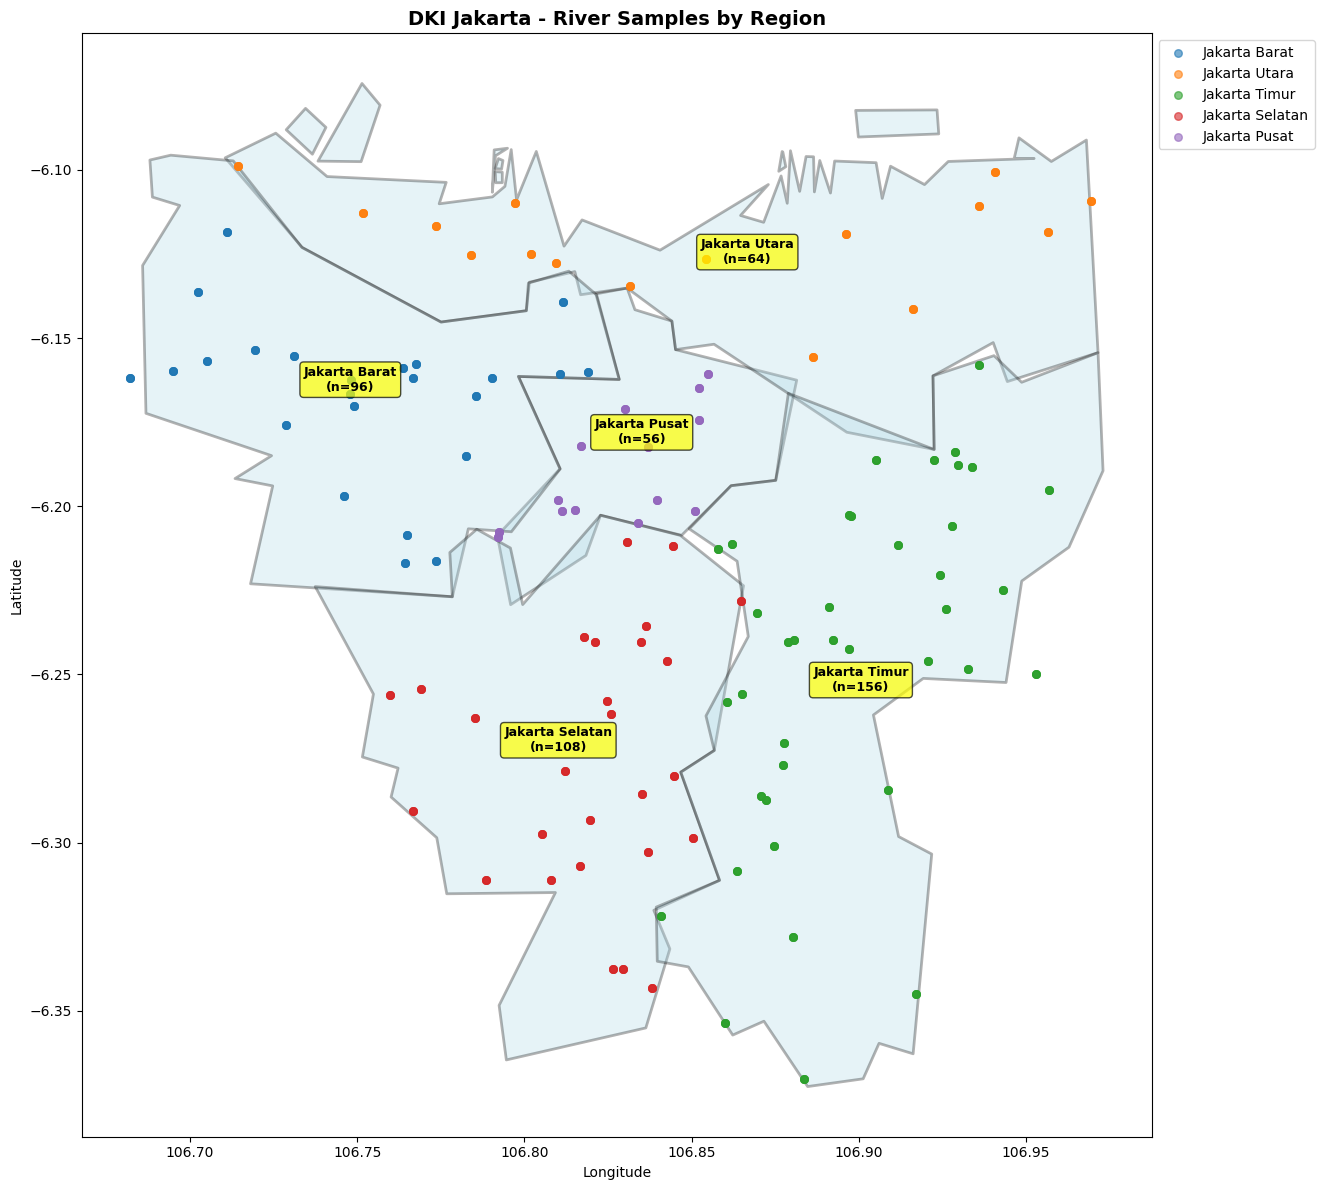

In [28]:
# Visualize regional assignments
fig, ax = plt.subplots(figsize=(14, 12))

# Plot boundaries
gdf_boundaries.plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.3, linewidth=2, aspect=None)

# Plot samples colored by region
for kota in gdf_sungai_with_region['kota_kabupaten'].unique():
    samples = gdf_sungai_with_region[gdf_sungai_with_region['kota_kabupaten'] == kota]
    samples.plot(ax=ax, markersize=30, alpha=0.6, label=kota.replace('Kota Administrasi ', ''))

# Add labels to boundaries
for _, row in gdf_boundaries.iterrows():
    centroid = row.geometry.centroid
    short_name = row['nama'].replace('Kota Administrasi ', '')
    count = (gdf_sungai_with_region['kota_kabupaten'] == row['nama']).sum()
    ax.annotate(text=f"{short_name}\n(n={count})", xy=(centroid.x, centroid.y), 
                ha='center', fontsize=9, weight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

ax.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True)
ax.set_title('DKI Jakarta - River Samples by Region', fontsize=14, weight='bold')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

## a

=== Top Positive Correlations with Kategori ===
max                  0.735798
pm_sepuluh           0.536592
karbon_monoksida     0.212268
ozon                 0.201385
nitrogen_dioksida    0.187744
pH mean              0.175811
pH median            0.163249
Sianida median       0.152339
sulfur_dioksida      0.124994
Cd mean              0.120796
Sianida mean         0.120789
Cd median            0.119111
Nitrat mean          0.111413
MBAS median          0.105226
COD mean             0.096271
Name: kategori_encoded, dtype: float64

=== Top Negative Correlations with Kategori ===
Total N median                  -0.020199
periode_data                    -0.022205
Fecal Coliform mean             -0.027173
Total Coliform mean             -0.029151
Nitrit median                   -0.029455
Total P mean                    -0.032947
Minyak dan Lemak median         -0.036522
Total P median                  -0.040886
TSS median                      -0.056437
Hg median                       -0.0

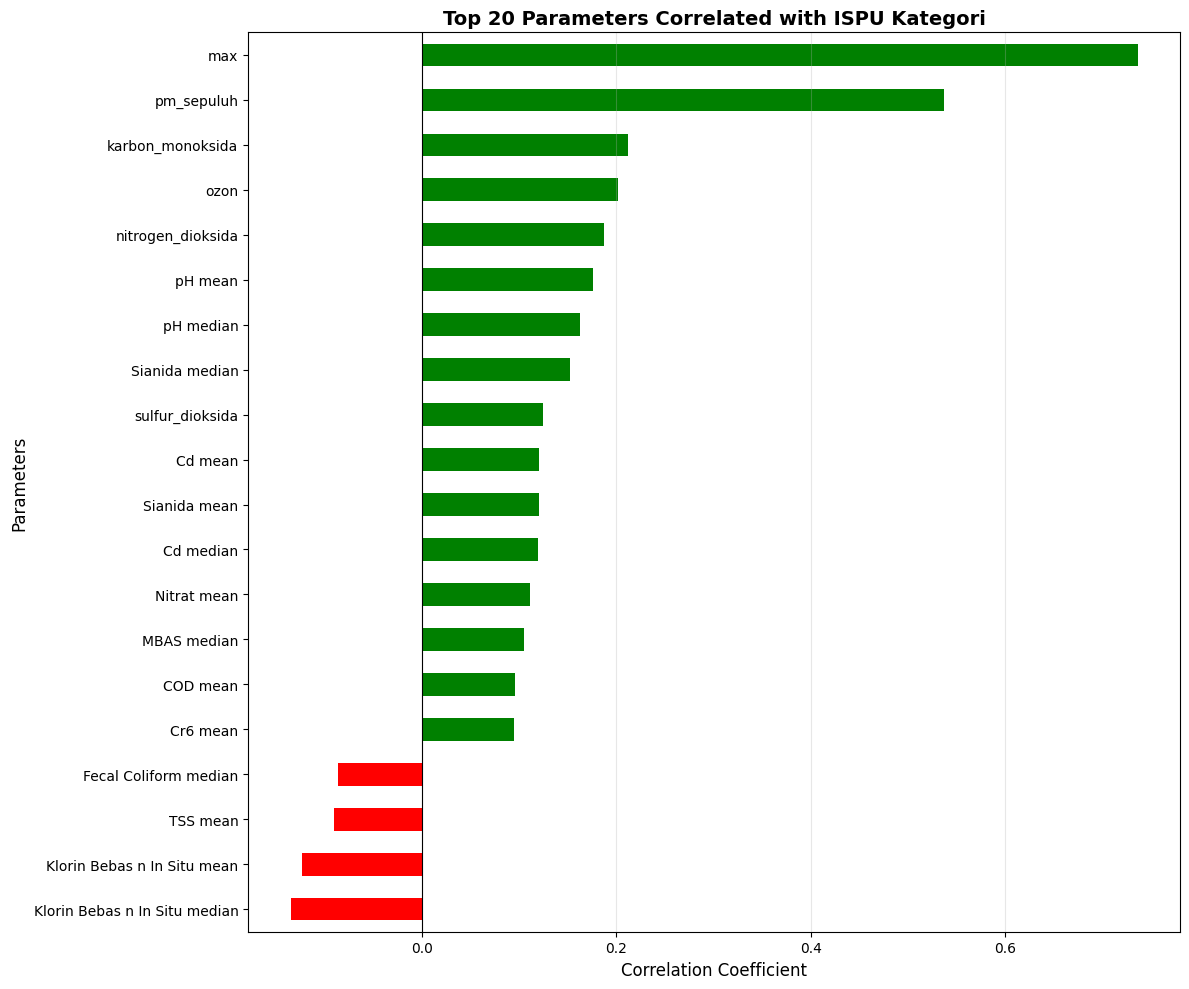

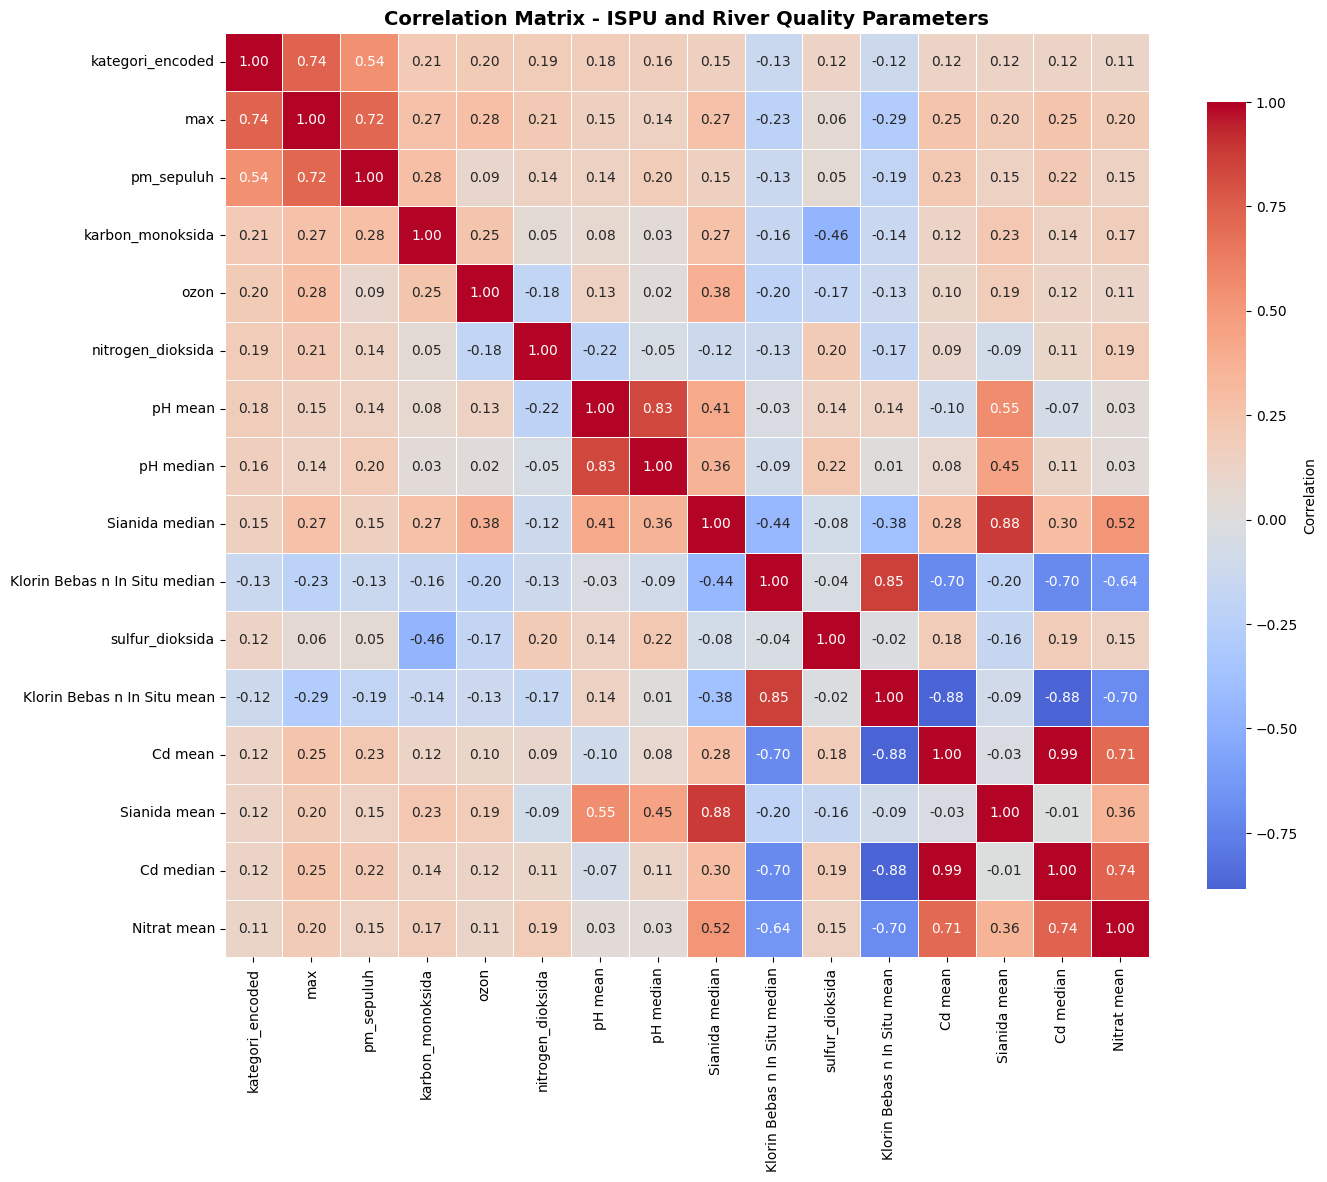

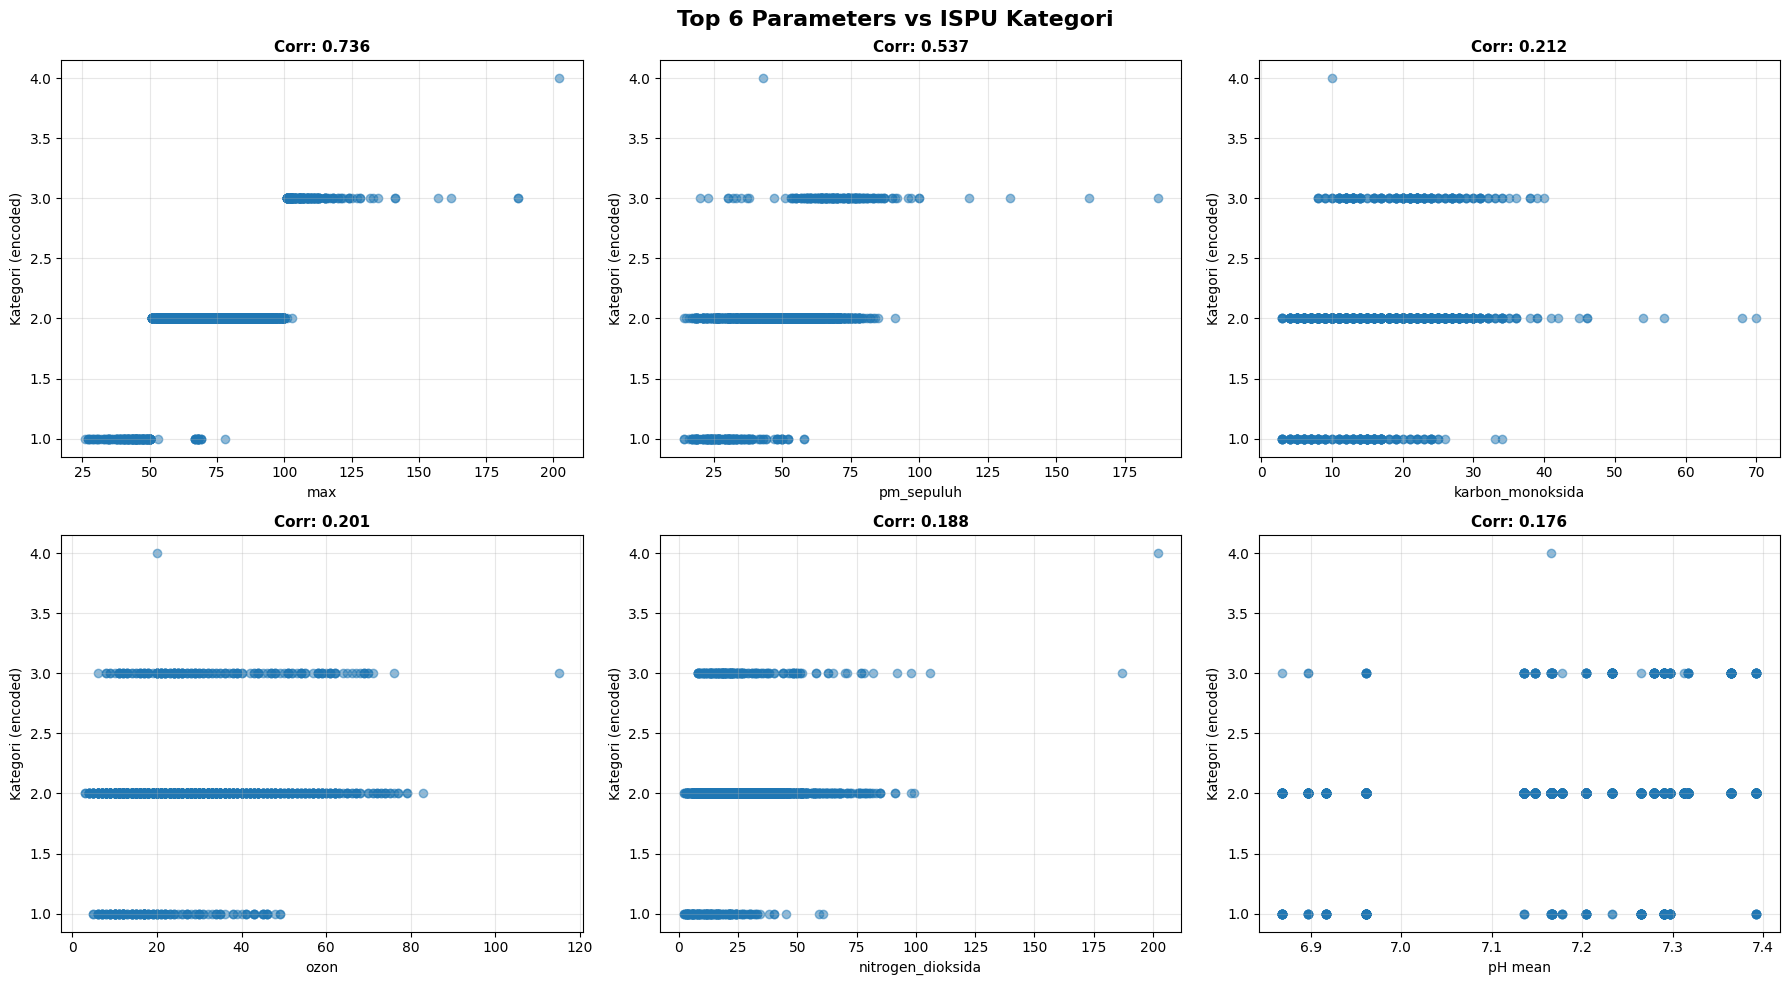

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Encode 'kategori' to numeric values
# Typical ISPU categories: BAIK < SEDANG < TIDAK SEHAT < SANGAT TIDAK SEHAT < BERBAHAYA
kategori_mapping = {
    'BAIK': 1,
    'SEDANG': 2,
    'TIDAK SEHAT': 3,
    'SANGAT TIDAK SEHAT': 4,
    'BERBAHAYA': 5
}

# Create a copy with encoded kategori
df_encoded = ispu_river_df.copy()
df_encoded['kategori_encoded'] = df_encoded['kategori'].map(kategori_mapping)

# Select only numeric columns including the encoded kategori
numeric_cols = df_encoded.select_dtypes(include=['number']).columns.tolist()

# Calculate correlation with kategori_encoded
correlations = df_encoded[numeric_cols].corr()['kategori_encoded'].sort_values(ascending=False)

# Display top correlations (excluding kategori_encoded itself)
print("=== Top Positive Correlations with Kategori ===")
print(correlations[correlations.index != 'kategori_encoded'].head(15))
print("\n=== Top Negative Correlations with Kategori ===")
print(correlations[correlations.index != 'kategori_encoded'].tail(15))

# Visualization 1: Bar plot of correlations with kategori
fig, ax = plt.subplots(figsize=(12, 10))
top_n = 20
top_correlations = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(top_n)
correlation_values = correlations[top_correlations.index].sort_values()

colors = ['red' if x < 0 else 'green' for x in correlation_values]
correlation_values.plot(kind='barh', color=colors, ax=ax)
ax.set_xlabel('Correlation Coefficient', fontsize=12)
ax.set_ylabel('Parameters', fontsize=12)
ax.set_title(f'Top {top_n} Parameters Correlated with ISPU Kategori', fontsize=14, weight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Focused heatmap with kategori and top correlated features
top_features = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(15).index.tolist()
focused_features = ['kategori_encoded'] + top_features
correlation_matrix_focused = df_encoded[focused_features].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix_focused, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8, "label": "Correlation"})
plt.title('Correlation Matrix - ISPU and River Quality Parameters', 
          fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

# Visualization 3: Scatter plots for top 6 correlated parameters
top_6_features = correlations[correlations.index != 'kategori_encoded'].abs().sort_values(ascending=False).head(6).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_6_features):
    ax = axes[idx]
    df_plot = df_encoded.dropna(subset=[feature, 'kategori_encoded'])
    ax.scatter(df_plot[feature], df_plot['kategori_encoded'], alpha=0.5)
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel('Kategori (encoded)', fontsize=10)
    ax.set_title(f'Corr: {correlations[feature]:.3f}', fontsize=11, weight='bold')
    ax.grid(alpha=0.3)

plt.suptitle('Top 6 Parameters vs ISPU Kategori', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# River Water Quality Data

In [143]:
def correct_num_format(df, cols):
    """
    Convert European number format (dot as thousands, comma as decimal) to standard format.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame to modify (modified in-place)
    cols : list
        List of column names to convert
    """
    for col in cols:
        if col in df.columns:
            df[col] = (
                df[col]
                .astype(str)
                .str.replace('.', '', regex=False)      # Remove thousands separator
                .str.replace(',', '.', regex=False)      # Replace decimal separator
                .replace(['', 'nan', 'None'], pd.NA)     # Handle empty/null strings
            )
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

## sampling location

In [145]:
import camelot

# 'lattice' flavor is best for tables with visible grid lines (like yours)
sampling_locs = camelot.read_pdf("airsungai_20250702121933.pdf", pages="60-62", flavor='lattice')

In [146]:
sampling_locs_header = ["No","Kode","Sungai","Sub Jaringan","Alamat","DAS","Lintang (DD)","Bujur (DD)","Lintang (DMS)","Bujur (DMS)"]
header_correction = {
    'Lintang (DD)': 'lat',
    'Bujur (DD)': 'lng'
}

In [153]:
slocs = []
for sloc in sampling_locs:
    df_sloc = sloc.df.iloc[2:]
    df_sloc.columns = sampling_locs_header
    df_sloc = df_sloc[['Kode', 'Lintang (DD)', 'Bujur (DD)']].rename(columns = header_correction)
    df_sloc = correct_num_format(df_sloc, ['lat', 'lng'])
    slocs.append(df_sloc)
slocs = pd.concat(slocs, ignore_index=True)


In [150]:
locs = sampling_locs[0].df.iloc[2:].copy()
locs.columns = sampling_locs_header
locs = locs[['Kode', 'Lintang (DD)', 'Bujur (DD)']].rename(columns = header_correction)
locs = correct_num_format(locs, ['lat', 'lng'])
locs

,Kode,lat,lng
2,1,-6.346678,106.838256
3,2C,-6.316256,106.851606
4,2,-6.302536,106.854367
5,2B,-6.258125,106.860367
6,2A,-6.228269,106.864536
7,3,-6.212717,106.857703
8,3B,-6.204903,106.834008
9,4,-6.200900,106.815217
10,5,-6.198944,106.810822
11,6,-6.116667,106.773497


In [159]:
# Convert locs to GeoDataFrame
gdf_slocs = gpd.GeoDataFrame(
    slocs,
    geometry=gpd.points_from_xy(slocs.lng, slocs.lat),
    crs='EPSG:4326'
)

# Spatial join with boundaries to get kota_kabupaten
gdf_slocs_with_region = gpd.sjoin(
    gdf_slocs,
    gdf_boundaries[['nama', 'geometry']],
    how='left',
    predicate='within'
)

# Clean up and assign to nearest if not within any boundary
if 'index_right' in gdf_slocs_with_region.columns:
    gdf_slocs_with_region = gdf_slocs_with_region.drop(columns=['index_right'])

gdf_slocs_with_region = gdf_slocs_with_region.rename(columns={'nama': 'kota_kabupaten'})

# Assign unassigned locations to nearest boundary
gdf_slocs_with_region = assign_to_nearest_region(gdf_slocs_with_region, gdf_boundaries, nama_col='kota_kabupaten')

# Convert back to DataFrame and add stasiun column
slocs_with_stasiun = pd.DataFrame(gdf_slocs_with_region.drop(columns=['lat', 'lng', 'geometry']))
slocs_with_stasiun['kota_kabupaten'] = slocs_with_stasiun['kota_kabupaten'].str.replace('Kota Administrasi ', '')
# Map to stasiun codes
slocs_with_stasiun = add_stasiun_column(slocs_with_stasiun, stasiun_mapping).drop(columns=['kota_kabupaten'])

slocs_with_stasiun

Assigning 6 samples to nearest boundaries...


,Kode,stasiun
0,1,DKI3
1,2C,DKI4
2,2,DKI3
3,2B,DKI4
4,2A,DKI3
...,...,...
106,23,DKI3
107,23A,DKI3
108,49,DKI5
109,49A,DKI5


## pdf loading 

|Tahun|Periode|page|
|---|---|---|
|2015|1|66|
|2015|2|69|
|2015|3|72|
|2016|1|75|
|2016|2|78|
|2017|1|81|
|2017|2|84|
|2017|3|87|
|2018|1|90|
|2018|2|93|
|2018|3|96|
|2018|4|99|
|2019|1|102|
|2019|2|105|
|2019|3|108|
|2019|4|111|

In [176]:
data_separation = {
    2015: 3,
    2016: 2,
    2017: 3,
    2018: 4,
    2019: 4
}

In [77]:
import camelot

# 'lattice' flavor is best for tables with visible grid lines (like yours)
tables = camelot.read_pdf("airsungai_20250702121933.pdf", pages="66-113", flavor='lattice')

In [99]:
numeric_cols = ["TDS", "TSS", "pH", "BOD", "COD", "Cd", "Cr6+", "Cu", "Pb", "Hg", "Zn", 
                "Minyak dan Lemak", "MBAS", "Bakteri Koli", "Bakteri Koli Tinja"]

In [103]:
headers = ["no", "Kode", "Sungai", "DAS", *numeric_cols]

In [180]:
river_params_dict = {
  "total_dissolved_solids": {
    "params1": "TDS",
    "params2": "TDS"
  },
  "total_suspended_solids": {
    "params1": "TSS",
    "params2": "TSS"
  },
  "ph": {
    "params1": "pH",
    "params2": "pH"
  },
  "biological_oxygen_demand": {
    "params1": "BOD",
    "params2": "BOD"
  },
  "chemical_oxygen_demand": {
    "params1": "COD",
    "params2": "COD"
  },
  "cadmium": {
    "params1": "Cd",
    "params2": "Cd"
  },
  "chromium_vi": {
    "params1": "Cr6+",
    "params2": "Cr6"
  },
  "copper": {
    "params1": "Cu",
    "params2": "Cu"
  },
  "lead": {
    "params1": "Pb",
    "params2": "Pb"
  },
  "mercury": {
    "params1": "Hg",
    "params2": "Hg"
  },
  "zinc": {
    "params1": "Zn",
    "params2": "Zn"
  },
  "oil_and_grease": {
    "params1": "Minyak dan Lemak",
    "params2": "Minyak dan Lemak"
  },
  "mbas_detergent": {
    "params1": "MBAS",
    "params2": "MBAS"
  },
  "total_coliform": {
    "params1": "Bakteri Koli",
    "params2": "Total Coliform"
  },
  "fecal_coliform": {
    "params1": "Bakteri Koli Tinja",
    "params2": "Fecal Coliform"
  }
}

rename_mapping = {v['params1']: k for k, v in river_params_dict.items()}
param_rename_map = {v['params1']: k for k, v in river_params_dict.items()}

In [177]:
data_separation.values()

dict_values([3, 2, 3, 4, 4])

In [ ]:
sum_n_tables = sum(data_separation.values())
processed_tables = 0
count = 0
tabs = []

# which year and number of table to process
for year, num_tables in data_separation.items():
    num = num_tables
    for n in range(num):
        # process the i+n, i+n+1, and i+n+2-th tables
        # 2 tables -> i+2, i+3, i+4
        for i in range(0, 3, 1):
            table = tables[processed_tables + n + i].df.iloc[5:]
            table.columns = headers
            table = correct_num_format(table.drop(columns = ["no"]))
            table = table.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left').reset_index(drop=True)
            table = table.rename(columns=param_rename_map)
            table_agg = table.groupby('stasiun').agg({
                col: ['mean', 'median'] for col in param_rename_map.values()
            }).reset_index()
            table_agg.columns = ['stasiun'] + [f'{col} {stat}' for col in param_rename_map.values() for stat in ['mean', 'median']]


In [216]:
sum_n_tables = sum(data_separation.values())
processed_tables = 0
tabs = []

# Process each year and its periods
for year, num_periods in data_separation.items():
    print(f"\n{'='*50}")
    print(f"Processing Year: {year} ({num_periods} periods)")
    print(f"{'='*50}")
    
    for period in range(1, num_periods + 1):
        print(f"\n--- Period {period} ---")
        # Each period has 3 pages (3 tables)
        table_indices = [processed_tables, processed_tables + 1, processed_tables + 2]
        print(f"Processing tables at indices: {table_indices}")
        
        period_dfs = []
        for idx in table_indices:
            table = tables[idx].df.iloc[5:].copy()
            table.columns = headers
            table = correct_num_format(table.drop(columns=["no"]), numeric_cols)
            table = table.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left')
            table = table.rename(columns=rename_mapping)
            period_dfs.append(table)
        
        # Combine all 3 tables for the period
        period_combined = pd.concat(period_dfs, ignore_index=True)
        
        _agg_list = ['mean']
        # Aggregate by stasiun
        period_agg = period_combined.groupby('stasiun').agg({
            col: _agg_list for col in rename_mapping.values()
        }).reset_index()
        
        if len(_agg_list) > 1:
            period_agg.columns = ['stasiun'] + [f'{col} {stat}' for col in rename_mapping.values() for stat in _agg_list]
        else:
            period_agg.columns = ['stasiun'] + [f'{col}' for col in rename_mapping.values()]
        period_agg['tahun'] = year
        period_agg['periode'] = period
        
        tabs.append(period_agg)
        print(f"✓ Period {period} processed")
        
        # Move to next period (3 tables forward)
        processed_tables += 3

print(f"\n{'='*50}")
print(f"Total periods processed: {len(tabs)}")
print(f"{'='*50}")

# Combine all periods
river_quality_all = pd.concat(tabs, ignore_index=True)
river_quality_all


Processing Year: 2015 (3 periods)

--- Period 1 ---
Processing tables at indices: [0, 1, 2]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [3, 4, 5]
✓ Period 2 processed

--- Period 3 ---
Processing tables at indices: [6, 7, 8]
✓ Period 3 processed

Processing Year: 2016 (2 periods)

--- Period 1 ---
Processing tables at indices: [9, 10, 11]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [12, 13, 14]
✓ Period 2 processed

Processing Year: 2017 (3 periods)

--- Period 1 ---
Processing tables at indices: [15, 16, 17]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [18, 19, 20]
✓ Period 2 processed

--- Period 3 ---
Processing tables at indices: [21, 22, 23]
✓ Period 3 processed

Processing Year: 2018 (4 periods)

--- Period 1 ---
Processing tables at indices: [24, 25, 26]
✓ Period 1 processed

--- Period 2 ---
Processing tables at indices: [27, 28, 29]
✓ Period 2 processed

--- Period 3 ---
Processing tables at indices: [3

,stasiun,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform,tahun,periode
0,DKI1,305.600000,123.800000,7.320000,19.780000,96.640000,0.009,0.003,0.009000,0.009500,0.000340,0.010000,820.000000,862.000000,7.440000e+06,2.736000e+06,2015,1
1,DKI2,1745.000000,77.923077,7.384615,21.369231,126.969231,0.009,0.003,0.002462,0.011250,0.000731,0.016923,410.000000,653.076923,4.141131e+06,1.281008e+06,2015,1
2,DKI3,266.650000,79.750000,7.200000,22.380000,143.000000,0.009,0.003,0.004450,0.019111,0.000345,0.018000,675.000000,739.500000,5.552500e+07,2.655895e+07,2015,1
3,DKI4,365.888889,99.185185,7.362963,18.825926,102.214815,0.009,0.003,0.015370,0.015741,0.000385,0.016296,326.666667,922.222222,2.462545e+07,5.938711e+06,2015,1
4,DKI5,567.842105,69.315789,7.410526,25.673684,141.168421,0.009,0.003,0.004000,0.017857,0.000816,0.064211,480.526316,725.263158,4.417526e+06,1.761684e+06,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,DKI1,351.750000,34.250000,6.733333,29.325000,82.566667,0.010,0.003,0.019000,NaN,0.000300,0.012500,497.308333,861.083333,3.494950e+08,2.174900e+08,2019,4
76,DKI2,1309.142857,40.642857,7.321429,25.142857,75.428571,0.010,0.003,0.019000,NaN,0.000300,0.027143,623.428571,951.500000,7.825533e+07,4.403949e+07,2019,4
77,DKI3,278.360000,50.000000,7.236000,34.568000,90.636000,0.010,0.003,0.019000,NaN,0.000300,0.010000,661.160000,765.960000,2.765987e+09,1.898678e+09,2019,4
78,DKI4,450.083333,54.111111,7.391667,41.202778,111.552778,0.010,0.003,0.019000,NaN,0.000300,0.012500,690.669444,1259.555556,6.415635e+08,4.027484e+08,2019,4


### testing

In [160]:
testdf = tables[0].df.iloc[5:].copy()
testdf.columns = headers
testdf = testdf.drop(columns = ["no"])

testdf = correct_num_format(testdf, numeric_cols)

# Merge with slocs_with_stasiun to add 'stasiun' column
testdf = testdf.merge(slocs_with_stasiun[['Kode', 'stasiun']], on='Kode', how='left')

# Check for unmatched codes
unmatched = testdf[testdf['stasiun'].isna()]['Kode'].unique()
if len(unmatched) > 0:
    print(f"Warning: {len(unmatched)} codes could not be matched:")
    print(unmatched)

testdf = testdf.reset_index(drop=True)
testdf

,Kode,Sungai,DAS,TDS,TSS,pH,BOD,COD,Cd,Cr6+,Cu,Pb,Hg,Zn,Minyak dan Lemak,MBAS,Bakteri Koli,Bakteri Koli Tinja,stasiun
0,1,Ciliwung,Ciliwung,132.0,12.0,7.3,4.6,15.5,0.009,0.003,0.001,0.004,0.0003,0.02,0.0,280.0,24000.0,3000.0,DKI3
1,2C,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI4
2,2,Ciliwung,Ciliwung,155.0,14.0,7.4,5.4,15.5,0.009,0.003,0.003,0.004,0.0010,0.02,250.0,170.0,28000.0,5000.0,DKI3
3,2B,Ciliwung,Ciliwung,210.0,84.0,7.2,11.7,31.1,0.009,0.003,0.004,0.010,0.0010,0.01,750.0,560.0,1400000.0,400000.0,DKI4
4,2A,Ciliwung,Ciliwung,175.0,36.0,7.3,11.2,31.1,0.009,0.003,0.001,0.006,0.0004,0.02,140.0,480.0,166000.0,46000.0,DKI3
5,3,Ciliwung,Ciliwung,196.0,64.0,7.2,10.3,31.1,0.009,0.003,0.002,0.005,0.0010,0.02,340.0,590.0,860000.0,290000.0,DKI4
6,3B,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
7,4,Ciliwung,Ciliwung,259.0,56.0,7.2,15.1,77.7,0.009,0.003,0.040,0.009,0.0003,0.00,250.0,1250.0,6700000.0,3000000.0,DKI1
8,5,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
9,6,Ciliwung,Angke-Pesanggrahan,776.0,73.0,6.7,16.1,78.4,0.009,0.003,0.005,0.010,0.0003,0.00,0.0,790.0,4000000.0,1100000.0,DKI2


In [162]:
testdf.columns

Index(['Kode', 'Sungai', 'DAS', 'TDS', 'TSS', 'pH', 'BOD', 'COD', 'Cd', 'Cr6+',
       'Cu', 'Pb', 'Hg', 'Zn', 'Minyak dan Lemak', 'MBAS', 'Bakteri Koli',
       'Bakteri Koli Tinja', 'stasiun'],
      dtype='str')

In [165]:
river_params_new = ['TDS', 'TSS', 'pH', 'BOD', 'COD', 'Cd', 'Cr6+',
       'Cu', 'Pb', 'Hg', 'Zn', 'Minyak dan Lemak', 'MBAS', 'Bakteri Koli',
       'Bakteri Koli Tinja']

In [ ]:
# Create a rename mapping from river_params_dict
rename_mapping = {v['params1']: k for k, v in river_params_dict.items()}

# Rename columns in testdf
testdf = testdf.rename(columns=rename_mapping)
testdf

Rename mapping:
{'TDS': 'total_dissolved_solids', 'TSS': 'total_suspended_solids', 'pH': 'ph', 'BOD': 'biological_oxygen_demand', 'COD': 'chemical_oxygen_demand', 'Cd': 'cadmium', 'Cr6+': 'chromium_vi', 'Cu': 'copper', 'Pb': 'lead', 'Hg': 'mercury', 'Zn': 'zinc', 'Minyak dan Lemak': 'oil_and_grease', 'MBAS': 'mbas_detergent', 'Bakteri Koli': 'total_coliform', 'Bakteri Koli Tinja': 'fecal_coliform'}

Renamed columns:
['Kode', 'Sungai', 'DAS', 'total_dissolved_solids', 'total_suspended_solids', 'ph', 'biological_oxygen_demand', 'chemical_oxygen_demand', 'cadmium', 'chromium_vi', 'copper', 'lead', 'mercury', 'zinc', 'oil_and_grease', 'mbas_detergent', 'total_coliform', 'fecal_coliform', 'stasiun']


,Kode,Sungai,DAS,total_dissolved_solids,total_suspended_solids,ph,biological_oxygen_demand,chemical_oxygen_demand,cadmium,chromium_vi,copper,lead,mercury,zinc,oil_and_grease,mbas_detergent,total_coliform,fecal_coliform,stasiun
0,1,Ciliwung,Ciliwung,132.0,12.0,7.3,4.6,15.5,0.009,0.003,0.001,0.004,0.0003,0.02,0.0,280.0,24000.0,3000.0,DKI3
1,2C,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI4
2,2,Ciliwung,Ciliwung,155.0,14.0,7.4,5.4,15.5,0.009,0.003,0.003,0.004,0.0010,0.02,250.0,170.0,28000.0,5000.0,DKI3
3,2B,Ciliwung,Ciliwung,210.0,84.0,7.2,11.7,31.1,0.009,0.003,0.004,0.010,0.0010,0.01,750.0,560.0,1400000.0,400000.0,DKI4
4,2A,Ciliwung,Ciliwung,175.0,36.0,7.3,11.2,31.1,0.009,0.003,0.001,0.006,0.0004,0.02,140.0,480.0,166000.0,46000.0,DKI3
5,3,Ciliwung,Ciliwung,196.0,64.0,7.2,10.3,31.1,0.009,0.003,0.002,0.005,0.0010,0.02,340.0,590.0,860000.0,290000.0,DKI4
6,3B,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
7,4,Ciliwung,Ciliwung,259.0,56.0,7.2,15.1,77.7,0.009,0.003,0.040,0.009,0.0003,0.00,250.0,1250.0,6700000.0,3000000.0,DKI1
8,5,Ciliwung,Ciliwung,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DKI1
9,6,Ciliwung,Angke-Pesanggrahan,776.0,73.0,6.7,16.1,78.4,0.009,0.003,0.005,0.010,0.0003,0.00,0.0,790.0,4000000.0,1100000.0,DKI2


In [172]:
testdf_agg = testdf.groupby('stasiun').agg({
    col: ['mean', 'median'] for col in rename_mapping.values()
}).reset_index()

testdf_agg.columns = ['stasiun'] + [f'{col} {stat}' for col in rename_mapping.values() for stat in ['mean', 'median']]

In [173]:
testdf_agg

,stasiun,total_dissolved_solids mean,total_dissolved_solids median,total_suspended_solids mean,total_suspended_solids median,ph mean,ph median,biological_oxygen_demand mean,biological_oxygen_demand median,chemical_oxygen_demand mean,chemical_oxygen_demand median,cadmium mean,cadmium median,chromium_vi mean,chromium_vi median,copper mean,copper median,lead mean,lead median,mercury mean,mercury median,zinc mean,zinc median,oil_and_grease mean,oil_and_grease median,mbas_detergent mean,mbas_detergent median,total_coliform mean,total_coliform median,fecal_coliform mean,fecal_coliform median
0,DKI1,244.500000,244.5,46.500000,46.5,7.250000,7.25,9.750000,9.75,54.550000,54.55,0.009,0.009,0.003,0.003,0.021000,0.021,0.009500,0.0095,0.000400,0.00040,0.000000,0.00,125.000000,125.0,1045.000000,1045.0,6.300000e+06,6300000.0,2.350000e+06,2350000.0
1,DKI2,689.000000,639.5,84.000000,72.0,7.200000,7.25,15.125000,16.10,82.325000,78.40,0.009,0.009,0.003,0.003,0.004750,0.004,0.010000,0.0100,0.000300,0.00030,0.010000,0.01,62.500000,0.0,747.500000,635.0,1.887500e+06,1640000.0,5.525000e+05,530000.0
2,DKI3,208.250000,165.0,31.000000,25.0,7.325000,7.30,13.925000,8.30,62.575000,23.30,0.009,0.009,0.003,0.003,0.003750,0.002,0.006000,0.0050,0.000500,0.00035,0.022500,0.02,1050.000000,195.0,397.500000,380.0,2.205450e+07,97000.0,8.263500e+06,25500.0
3,DKI4,383.571429,373.0,87.571429,84.0,7.328571,7.20,20.071429,15.30,124.457143,125.50,0.009,0.009,0.003,0.003,0.003429,0.003,0.009286,0.0100,0.000529,0.00030,0.008571,0.01,440.000000,420.0,861.428571,720.0,6.013714e+07,7400000.0,1.118429e+07,2400000.0
4,DKI5,334.857143,355.0,59.142857,42.0,7.371429,7.40,20.100000,12.10,95.657143,77.70,0.009,0.009,0.003,0.003,0.003714,0.001,0.010000,0.0100,0.000400,0.00030,0.008571,0.01,641.428571,100.0,750.000000,760.0,4.522857e+06,1190000.0,1.894286e+06,330000.0


## csv loading

In [292]:
sungai_df = pd.read_csv('sungai2022.csv', sep = ";")
sungai_df = correct_num_format(sungai_df, ['lintang', 'bujur', 'hasil_pengukuran'])
sungai_df = sungai_df[['tahun', 'bulan_sampling', 'lintang', 'bujur','jenis_parameter', 'parameter', 'hasil_pengukuran']]

In [293]:
sungai_df.columns

Index(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'jenis_parameter',
       'parameter', 'hasil_pengukuran'],
      dtype='str')

In [260]:
sungai_df['jenis_parameter'].value_counts()

jenis_parameter
KIMIA        11282
FISIKA        1318
BIOLOGI        960
NILAI IP       475
STATUS IP      475
Name: count, dtype: int64

In [301]:
sungai_df

,tahun,bulan_sampling,lintang,bujur,jenis_parameter,parameter,hasil_pengukuran
0,2022,202203,-6.292639,106.853500,KIMIA,F,0.019000
1,2022,202203,-6.292639,106.853500,KIMIA,H2S,0.011000
2,2022,202203,-6.292639,106.853500,KIMIA,KLORIN BEBAS,0.390000
3,2022,202203,-6.292639,106.853500,KIMIA,HG,0.000049
4,2022,202203,-6.292639,106.853500,KIMIA,KADMIUM CD,0.005900
...,...,...,...,...,...,...,...
14507,2022,202210,-6.290602,106.766668,KIMIA,SULFAT,10.400000
14508,2022,202210,-6.290602,106.766668,KIMIA,KLORIDA,32.150000
14509,2022,202210,-6.290602,106.766668,KIMIA,AMONIAK,0.250000
14510,2022,202210,-6.290602,106.766668,KIMIA,TOTAL N,NaN


In [295]:
params_sungai = ['KIMIA', 'FISIKA', 'BIOLOGI'] 

index_columns = ['tahun', 'bulan_sampling', 'lintang', 'bujur']
parameter_columns = 'parameter'
value_columns = 'hasil_pengukuran'

In [303]:
sungai_df = sungai_df.groupby(['tahun', 'bulan_sampling', 'lintang', 'bujur', 'jenis_parameter', 'parameter'], as_index=False)['hasil_pengukuran'].mean()

sungai_dfs = []
for param in params_sungai:
    _sungai_df = sungai_df[sungai_df['jenis_parameter'] == param]
    _sungai_df = _sungai_df.pivot(index=index_columns, columns=parameter_columns, values=value_columns)
    _sungai_df = _sungai_df.reset_index()
    print(len(_sungai_df))
    sungai_dfs.append(_sungai_df)

478
478
478


In [271]:
sungai_df['parameter'][sungai_df['jenis_parameter'] == 'KIMIA']

0                   F
1                 H2S
2        KLORIN BEBAS
3                  HG
4          KADMIUM CD
             ...     
14507          SULFAT
14508         KLORIDA
14509         AMONIAK
14510         TOTAL N
14511              NI
Name: parameter, Length: 11282, dtype: str

In [306]:
sungai_df['hasil_pengukuran'][(sungai_df['jenis_parameter'] == 'KIMIA') & (sungai_df['parameter'] == "TOTAL N")].count()

np.int64(0)